# Machine Learning @ UWr 2022

**Lecture 03**

# Tuning 

Let's get back one more time to k-Nearest Neighbors on MNIST. Since `k` is the essential parameter of the model, a natural question is: which `k` is the best? And what does it even mean?

In [30]:
from sklearn.neighbors import KNeighborsClassifier
import numpy as np

In [36]:
with np.load('mnist.npz') as data:
    X_trn = data['train_data']
    y_trn = data['train_labels']
    X_tst = data['test_data']
    y_tst = data['test_labels']
print(X_trn.shape)

(60000, 28, 28)


In [83]:
def eval(TRN_SIZE, k):
    model = KNeighborsClassifier(n_neighbors=k)
    model.fit(X_trn[:TRN_SIZE].reshape(-1,28*28), y_trn[:TRN_SIZE]) 

    y_trn_pred = model.predict(X_trn[:TRN_SIZE].reshape(-1,28*28))
    print("trn accuracy:", (y_trn_pred == y_trn[:TRN_SIZE]).mean())

    y_tst_pred = model.predict(X_tst.reshape(-1,28*28))
    print("trn accuracy:", (y_tst_pred == y_tst).mean())

In [87]:
ks = [1,2,3,4,5,16,64]

In [88]:
for k in ks:
    print("\nk:", k)
    eval(TRN_SIZE=100, k=k)


k: 1
trn accuracy: 1.0
trn accuracy: 0.6794

k: 2
trn accuracy: 0.91
trn accuracy: 0.6456

k: 3
trn accuracy: 0.87
trn accuracy: 0.6476

k: 4
trn accuracy: 0.89
trn accuracy: 0.6426

k: 5
trn accuracy: 0.83
trn accuracy: 0.6232

k: 16
trn accuracy: 0.72
trn accuracy: 0.5194

k: 64
trn accuracy: 0.26
trn accuracy: 0.2255


In [89]:
for k in ks:
    print("\nk:", k)
    eval(TRN_SIZE=1000, k=k)


k: 1
trn accuracy: 1.0
trn accuracy: 0.869

k: 2
trn accuracy: 0.935
trn accuracy: 0.8496

k: 3
trn accuracy: 0.925
trn accuracy: 0.8622

k: 4
trn accuracy: 0.917
trn accuracy: 0.8634

k: 5
trn accuracy: 0.908
trn accuracy: 0.8582

k: 16
trn accuracy: 0.86
trn accuracy: 0.8239

k: 64
trn accuracy: 0.779
trn accuracy: 0.7306


In [90]:
for k in ks:
    print("\nk:", k)
    eval(TRN_SIZE=10000, k=k)


k: 1
trn accuracy: 1.0
trn accuracy: 0.9463

k: 2
trn accuracy: 0.9738
trn accuracy: 0.9335

k: 3
trn accuracy: 0.9755
trn accuracy: 0.9463

k: 4
trn accuracy: 0.9685
trn accuracy: 0.9442

k: 5
trn accuracy: 0.9669
trn accuracy: 0.9442

k: 16
trn accuracy: 0.9448
trn accuracy: 0.9346

k: 64
trn accuracy: 0.9106
trn accuracy: 0.9068


In [91]:
for k in ks:
    print("\nk:", k)
    eval(TRN_SIZE=60000, k=k)


k: 1
trn accuracy: 1.0
trn accuracy: 0.9691

k: 2
trn accuracy: 0.9857333333333334
trn accuracy: 0.9627

k: 3
trn accuracy: 0.9867166666666667
trn accuracy: 0.9705

k: 4
trn accuracy: 0.9829833333333333
trn accuracy: 0.9682

k: 5
trn accuracy: 0.9819166666666667
trn accuracy: 0.9688

k: 16
trn accuracy: 0.9695666666666667
trn accuracy: 0.9632

k: 64
trn accuracy: 0.9491333333333334
trn accuracy: 0.9498


## Tuning k-Nearest Neighbors on Iris



We will now develop and tune our first learning model for Iris: a nearest neighbor based model.


In [15]:
import numpy as np
import pandas as pd
import sklearn
import sklearn.model_selection
import sklearn.datasets
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn.neighbors

iris = sklearn.datasets.load_iris()
iris_df = pd.DataFrame(iris.data, columns=iris.feature_names)
iris_df['target'] = pd.Categorical(iris.target_names[iris.target])
iris_df.loc[[0,1,50,51,100,101]]

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
50,7.0,3.2,4.7,1.4,versicolor
51,6.4,3.2,4.5,1.5,versicolor
100,6.3,3.3,6.0,2.5,virginica
101,5.8,2.7,5.1,1.9,virginica


Before we begin, let's split our Iris dataset into two parts: 
- a training dataset, containing 2/3 of data samples
- a validating dataset, containing the remaining 1/3 of data.

We will use the training dataset to find the nearest neighbors and the validating dataset to choose important hyper-parameters of our model. Technically, we should also have a test set. We omit forming one for two reasons: 1. to have a simpler demonstration and 2. because our data is small. 



Technical sidenote: we pass the data splitting function a `random_state` parameter which helps in reproducibility - each run of this code uses the same sequence of pseudo-random numbers.

In [16]:
iris_trn_df, iris_val_df = sklearn.model_selection.train_test_split(iris_df, train_size=0.67, random_state=1234)

print(f"The training dataset contains {iris_trn_df.shape[0]} samples.")
print(f"The validating dataset contains {iris_val_df.shape[0]} samples.")

The training dataset contains 100 samples.
The validating dataset contains 50 samples.


We will want to visualize how the model performs. to this end our classifiers will depend only on two features: petal length and sepal lentgh.

In [17]:
feature_cols = ['petal length (cm)', 'sepal length (cm)']
target_col = 'target'

To classify a sample the `sklearn.neighbors.KNeighborsClassifier` works as follows:
1. it computes the distance from the sample to all training data samples
2. it choses `n_neighbors` closest ones
3. chosen neighbors vote on the classification.

The `n_neighbors` parameter is very important, as we will see it controls how smooth is the decision boundary of the classifier. Thus, we will choose the best one using our development set.

/Users/marek-ext/ml_uwr_22/uwr_venv/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/Users/marek-ext/ml_uwr_22/uwr_venv/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/Users/marek-ext/ml_uwr_22/uwr_venv/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/Users/marek-ext/ml_uwr_22/uwr_venv/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/Users/marek-ext/ml_uwr_22/uwr_venv/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted w

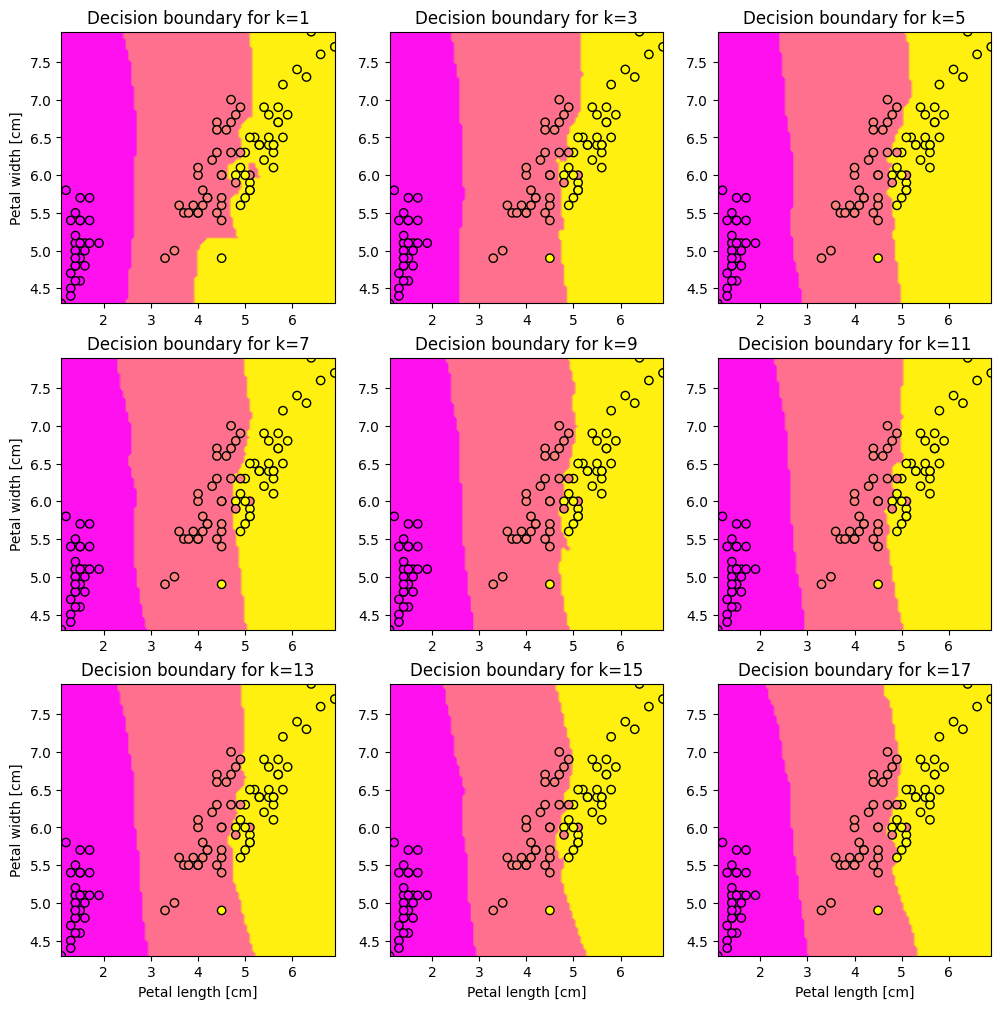

In [26]:
# The mesh will list all points on a MESH_SIZE x MESH_SIZE grid
# We will classify them to deomnstrate how the model wirks on points
# outside the training dataset
MESH_SIZE = 100
mesh_x, mesh_y = np.meshgrid(
    np.linspace(iris_trn_df[feature_cols[0]].min(), iris_trn_df[feature_cols[0]].max(), MESH_SIZE),
    np.linspace(iris_trn_df[feature_cols[1]].min(), iris_trn_df[feature_cols[1]].max(), MESH_SIZE),
)
mesh = np.hstack([mesh_x.reshape(-1, 1), mesh_y.reshape(-1, 1)])

# Results will contain a table of number of neighbors and model accuracies 
results = []

plt.figure(figsize=(12, 12))
# Finally, in a loop we run the model with various settings of the n_neighbors hyper-parameter
for i, n_neighbors in enumerate([1, 3, 5, 7, 9, 11, 13, 15, 17]):
    # First, fit the model. For a nearest neoghbors model, this merely remebers the training datasset
    model = sklearn.neighbors.KNeighborsClassifier(n_neighbors=n_neighbors)
    model.fit(iris_trn_df[feature_cols], iris_trn_df[target_col])
    
    # Now apply the model to development data and ecord the accuracy
    train_predictions = model.predict(iris_trn_df[feature_cols])
    train_accuracy = sklearn.metrics.accuracy_score(iris_trn_df[target_col], train_predictions)
    
    # Now apply the model to development data and ecord the accuracy
    predictions = model.predict(iris_val_df[feature_cols])
    accuracy = sklearn.metrics.accuracy_score(iris_val_df[target_col], predictions)
    results.append(dict(n_neighbors=n_neighbors, accuracy=accuracy, train_accuracy=train_accuracy))
    
    # Finally, plot the decision boundary
    mesh_predictions = model.predict(mesh)
    # now encode the predictions as a categorical variable, using the same dictionary of categories
    mesh_predictions = pd.Categorical(mesh_predictions, categories=iris_trn_df[target_col].cat.categories)
    # the `.cat.codes` property of a categorical dataframe column changes the string values into integers
    # plt.figure(facecolor='w')
    plt.subplot(3, 3, i + 1)
    plt.title(f"Decision boundary for k={n_neighbors}")
    plt.contourf(mesh_x, mesh_y, mesh_predictions.codes.reshape(mesh_x.shape), cmap='spring')
    plt.scatter(iris_trn_df[feature_cols[0]], iris_trn_df[feature_cols[1]], c=iris_trn_df[target_col].cat.codes, 
                cmap='spring', linewidths=1, edgecolors='black')
    if i >= 6:
        plt.xlabel('Petal length [cm]')
    if i % 3 == 0:
        plt.ylabel('Petal width [cm]')

plt.axis('tight')

# Construct a pd.DataFrame out of our results list, it will be easier to analyse it
results_df = pd.DataFrame(results)

We can see that the `n_neighbors` parameter has a large influence on the boundary: the higher it is,
the smoother the boundary. 

The influence of `n_neighbors` on model accuracy is also visible:

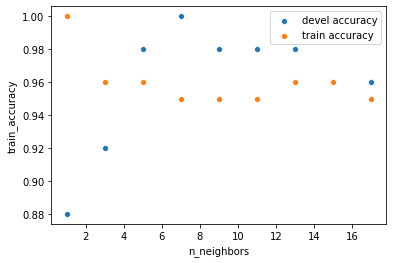

In [ ]:
sns.scatterplot(x='n_neighbors', y='accuracy', data=results_df)
sns.scatterplot(x='n_neighbors', y='train_accuracy', data=results_df)
plt.legend(['devel accuracy', 'train accuracy'])

For low values of `n_neighbors` the model has a high training accuracy
(for `n_neighbors=1` train accuracy is 100%!), but lower test accuracy. Smoothing out the decision boundary makes development accuracy 
higher, at the expense of training one. This is however good - our ultimate goal is **generalization** to new data, and not memorizing
the train set. From this perspective, choosing `n_neighbors=7` seems like a good option.

Finally, you may be puzzled why on this example the development accuracy is sometimes higher than training one. This is an artifact of 
our data split - we have very small datasets, and if one contains more examples of the easy setosa class, the model will be more accurate on it.
This issue would be resolved using cross-validation.

### Practical aspects of using K-Nearest neighbors classifiers.

K-nearest neighbors is a very simple classification algorithm. It works well if two conditions are met:
1. we have a meaningful distance measure for our data, in other words we know how to compare two samples.
2. the test data are always close (according to our distance measure) to some training data.

The first issue requires for instance proper data scaling, such that one feature does not dominate the distance computations.

The second issue is more complex and is often called "the curse of dimensionality".


#### The curse of dimensionality
When data live in many dimensions, the total volume available to data is large, and the datapoints are far away from each other. This hurts and neighborhood distance-based methods.

The following pictures try to convey some intuitions about this phenomenon.

Forse notice, how empty is the 2D space when it is populated by just three points.
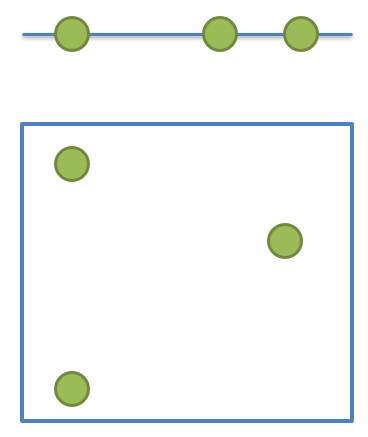

The emptiness of large dimensional spaces becomes even more severe in higher dimensional spaces. The following figure, taken from Kevin's Murphy textbook showv the fraction of volume that the small cube occupies inside the large cube. When the data is uniformily distributed in the space, this corresponds to the fraction of data in a small neighborhood.

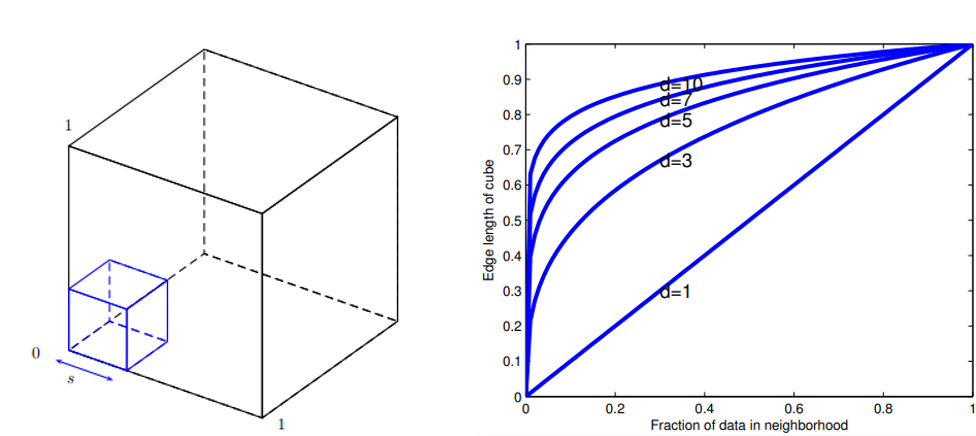

Even for moderate numbers of dimensions the small cube must be nearly as large as the large cube, to contain a non-negligible fraction of data.

This means, that in highly-dimensional spaces there are no near neoghbors, all points are far away,

#### K-NN scaling with amount of data

The impact of data dimensionality can be seen on results of the MNIST classification task.

Each MNIST sample is a small image (28x28 pixels) containing a single, centered handwritten digit:
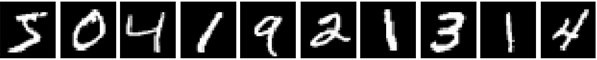

The goal si to detect which digit is in each picture.

A k-Nearest Neighors runs surprisingly well on MNIST (mainly due to the extensive image preprocessing that was applied to the images: all digits are cut out form the background, centered, and equalized in size).

The plot below shows the accurracy of a neares neighbors classifier in function of the number of training data:
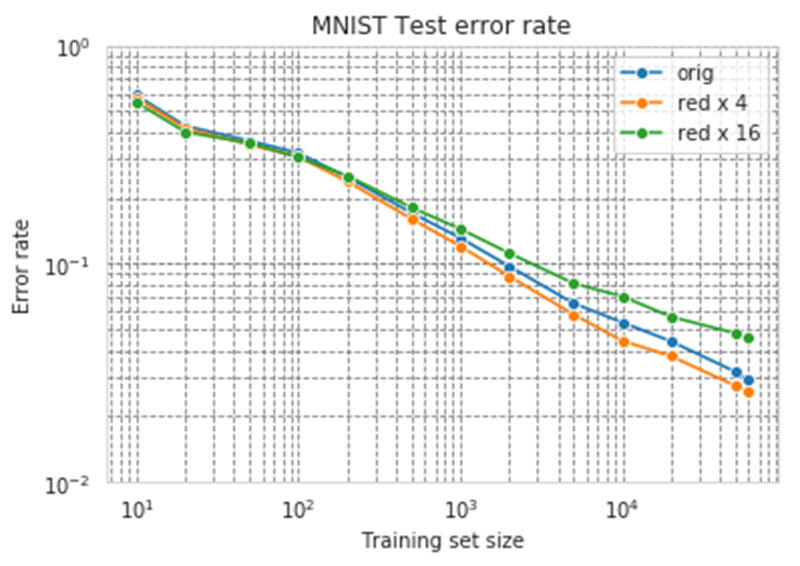

We can see that the accuracy increases (error rate drops down) when the amount of trainign data increases. moreover, there is no saturation in sight - while not economical, the model probably would keep getting better with more data.

This observation makes nearest neighbor models useful in many big data tasks - when the problem is not complictaed, and the data abundant.

However, a small performance increase is also possible by simple downscaling the data by 2, which reduces the problem's dimensionality from $28\cdot 28=784$ dimensions to $14\cdot 14 = 196$ dimensions. This slightly alleviates the curse of dimensionality. Further reductions of the size however are detrimental, we can hypothesize that when the images are reduced to 7x7 pixels, they are too small to represent the fine details which can e.g. tell apart a 1 from a 7.

### Better test error estimators.

Performing a simple train-test split on small datasets usually is wasteful of data, and the results heavily depend on the composition of the train and test splits. Intuitively, for the Iris task, the error rate can be low if a set contains many setosas.

Rather than using a single trian-test split, one can use several ones. In the *$K$-fold cross-validation* approach, the data is divided into $K$ folds. Next, $K$ evaluation rounds are run. During each of them, one fold is used for testing, while all the other ones are used for training.

In the extreme case, when the number of folds equals the size of the dataset, we talk about leave-one-out validation or the "jackknife" estimation.

Another approach is to repeatedely randomly split the data into a training and testing set, then average the results across all runs. This is called a _bootstrap_ estimator.

## Summary

Machine learnign is implementing functions that are defined using data. It can be used whenever it is easy to get examples, but hard to devise an exact algorithm. Practical examples include computer vision, speech recognition, language processing, translation -- all state-of-the-art approaches rely heavily on data.

Moreover, machine learning is about problem solving. It thrives on good, data-driven, performance measures, and cares about models which perform the desired tasks well.